<a href="https://colab.research.google.com/github/austinli356/DRUG-HIA-GCN/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone OTGK Code

import shutil
import os, sys

shutil.rmtree('/content/OTGK_DP', ignore_errors=True)

!git clone https://github.com/Maburidi/OTGK_DP.git

sys.path.insert(0,'/content/OTGK_DP/')

Cloning into 'OTGK_DP'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 198 (delta 8), reused 0 (delta 0), pack-reused 182 (from 1)
Receiving objects: 100% (198/198), 51.22 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
# Install dependencies

!bash OTGK_DP/install_dependencies.sh

In [ ]:
# Data processing

import numpy as np
import random
import os, sys
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from sklearn.svm import SVC
from sklearn.svm import SVR
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as DL

from models import KNNClassifier
from models import KernelRegressionNN

from Gbuilder import *
from OTtools import *
from utils import *


#----------- Model Inputs ------------------------
set_name ='HIA_Hou'       # Choose dataset
sets = 'ADME'                     # The prediction task, (ADME, Tox)
task = 'classification'               # The type of the task to be done, (classification vs regression)
#---------------- Specify the measure/embdgs + and the distance metrix used in the cost matrix ---------
embdgs = False                    # If you apply an embedding scheme at the extracted features or not
otsolver = 'wasserstein'         # The used optimal transport method, GWasserstein, wasserstein, FGW
fm = 'euclidean'                  # The distance metrix to be applied in order to generate the cost matrix needed for optimal transport
gamma = 3                        # The scaling parameter used in the kernel

norm = False                      # Normalize the features on the nodes
save_sim = False
run_MLP = True
#----------------Load and Split Dataset-----------------------------------------
if sets == 'ADME':
    data = ADME(name = set_name)
else:
    data = Tox(name = set_name)

dall = data.get_data()
split = data.get_split(method = 'scaffold', seed = 42, frac = [0.8, 0.0, 0.2])
Train = split['train']
Test = split['test']
# y_train = list(Train['Y'])
# y_test = list(Test['Y'])
# print('===========================================')
# print(f'Number of data points = {len(y_train) + len(y_test)}')
# if task == 'classification':
#     print(f'Percent of positive data points = {np.sum(y_train) / len(y_train) * 100:.2f}%')

#------------------- extract graph features ---------------------
def process_data(data):
  compound_iso_smiles = list(data['Drug'])
  smile_graph = {}                      # Dictinary of features
  structure_graph = {}
  for smile in compound_iso_smiles:
      g, feat_, _, _  = smile_to_graph2(smile, normalize= norm)
      smile_graph[smile] = feat_
      if otsolver != 'Wasserstein':
          #g, feat_, _, _  = smile_to_graph2(smile, normalize= norm)
          C = structure_matrix(g, method='adjency')     # harmonic_distance, adjency, shortest_path
          structure_graph[smile] = C

  # Create Data object for training and testing from smile_graph and structure_graph dict
  graph_data_list = []
  # Counter used to include Y
  i = 0
  for smile, features in smile_graph.items():
      # Node features (x)
      x = torch.tensor(features, dtype=torch.float)  # Ensure feature array is in the correct format

      # Edge index
      edge_matrix = structure_graph[smile]
      edge_index = torch.tensor(np.array(edge_matrix.nonzero()), dtype=torch.long)  # Convert adjacency matrix to edge list format

      # Target label (y)
      y = torch.tensor([data['Y'][i]], dtype=torch.long)
      # Create Data object with x, edge_index, and y
      graph_data = Data(x=x, edge_index=edge_index, y=y)
      graph_data_list.append(graph_data)
      i+=1
  return graph_data_list

Error importing huggingface_hub.hf_api: cannot import name 'logging' from 'huggingface_hub' (/usr/local/lib/python3.10/dist-packages/huggingface_hub/__init__.py)


ImportError: cannot import name 'logging' from 'huggingface_hub' (/usr/local/lib/python3.10/dist-packages/huggingface_hub/__init__.py)

In [ ]:
# Model

embedding_size = 16

class GCN(nn.Module):
  # Init parent
  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)

    # Convolutional Layers
    self.conv0 = GCNConv(4, embedding_size)
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)

    #Linear layer takes input after global mean pooling and global max pooling is concatinated, taking input of 2 x embedding_size
    self.out = Linear(2*embedding_size, 2)

  def forward(self, x, edge_index, batch_index):
    x = F.relu(self.conv0(x, edge_index))
    x = F.relu(self.conv1(x, edge_index))
    x = F.relu(self.conv2(x, edge_index))
    x = F.relu(self.conv3(x, edge_index))

    #Pooling
    x = torch.cat([gmp(x, batch_index),
                        gap(x, batch_index)], dim=1)

    out = self.out(x)

    return out, x

In [ ]:
# Train Model

model = GCN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_size = len(dall['Drug'])
batch = 48

# Split data
train_graph_data = process_data(Train)
test_graph_data = process_data(Test)

# Create DataLoaders
train_loader = DL(train_graph_data, batch_size=batch, shuffle=True)
test_loader = DL(test_graph_data, batch_size=batch, shuffle=True)

def train(data):
  for batch in train_loader:
    batch.to(device)

    #zero the gradient
    optimizer.zero_grad()

    pred, embedding = model(batch.x, batch.edge_index, batch.batch)

    # Calculate loss and conduct back prop
    loss = loss_function(pred, batch.y)
    loss.backward()
    optimizer.step()

  return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data) # Get loss from training
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 0.6534513235092163
Epoch 100 | Train Loss 0.306775838136673
Epoch 200 | Train Loss 0.25166890025138855
Epoch 300 | Train Loss 0.2892746925354004
Epoch 400 | Train Loss 0.1406518518924713
Epoch 500 | Train Loss 0.21045343577861786
Epoch 600 | Train Loss 0.29576632380485535
Epoch 700 | Train Loss 0.2766011953353882
Epoch 800 | Train Loss 0.26502275466918945
Epoch 900 | Train Loss 0.09954014420509338
Epoch 1000 | Train Loss 0.1667754203081131
Epoch 1100 | Train Loss 0.25962749123573303
Epoch 1200 | Train Loss 0.133261039853096
Epoch 1300 | Train Loss 0.33859023451805115
Epoch 1400 | Train Loss 0.19770926237106323
Epoch 1500 | Train Loss 0.09920991957187653
Epoch 1600 | Train Loss 0.05106402561068535
Epoch 1700 | Train Loss 0.1297272890806198
Epoch 1800 | Train Loss 0.22665360569953918
Epoch 1900 | Train Loss 0.22931218147277832


In [ ]:
# Test Model

correct = 0
total = 0
y_real = []
y_pred = []

model.eval()

with torch.no_grad():
    for test_batch in test_loader:
        test_batch.to(device)

        # Get predictions
        pred, _ = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)

        # Get the predicted class
        predicted_classes = pred.argmax(dim=1)

        # Update the count of correctly classified samples

        correct += (predicted_classes == test_batch.y).sum().item()
        total += test_batch.y.size(0)

        y_real.extend(test_batch.y.cpu().numpy())
        y_pred.extend(predicted_classes.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 91.38%


In [ ]:
# Predict Single Instance

model.eval()

def predict_smile(smile):

    g, feat_, _, _ = smile_to_graph2(smile, normalize=norm)

    edge_matrix = structure_matrix(g, method='adjency')
    edge_index = torch.tensor(np.array(edge_matrix.nonzero()), dtype=torch.long)

    x = torch.tensor(feat_, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index)
    data = data.to(device)

    # Make prediction
    with torch.no_grad():
        pred, _ = model(data.x, data.edge_index, torch.zeros(data.x.size(0), dtype=torch.long, device=device))
        predicted_class = pred.argmax(dim=1).item()  # Get predicted class (0 or 1)

    return predicted_class


smile_string = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
predicted_class = predict_smile(smile_string)
print(f"The predicted class for the SMILES '{smile_string}' is: {predicted_class}")

The predicted class for the SMILES 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C' is: 1


<Axes: >

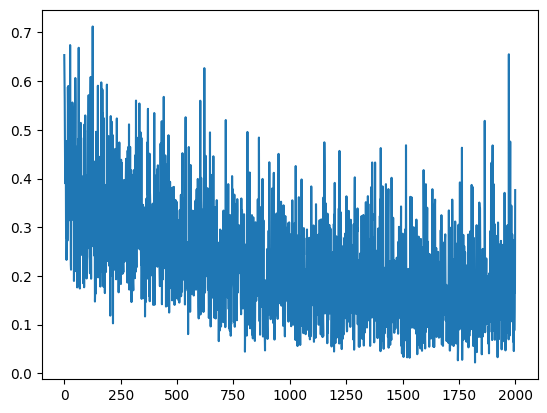

In [ ]:
# Visualize training loss
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(losses_float)
plt

In [ ]:
import pandas as pd

df = pd.DataFrame({'y_real': y_real, 'y_pred': y_pred})
df[df['y_real'] == 0]

,y_real,y_pred
3,0,1
4,0,1
13,0,1
18,0,0
30,0,1
38,0,1
39,0,0
43,0,0
49,0,0
56,0,0


from matplotlib import pyplot as plt
_df_22['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['y_pred'].plot(kind='hist', bins=20, title='y_pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='index', y='y_pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['y_pred']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('y_pred')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['y_real']
  ys = series['y_pred']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('y_real', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('y_real')
_ = plt.ylabel('y_pred')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['y_real']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'y_real'}, axis=1)
              .sort_values('y_real', ascending=True))
  xs = counted['y_real']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('y_real', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('y_real')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_29['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['y_pred'].plot(kind='line', figsize=(8, 4), title='y_pred')
plt.gca().spines[['top', 'right']].set_visible(False)